# Countries Temperature and Climate

In this notebook, we will investigate a data set containing the average monthly temperature of countries from across the globe. This data set is publicly avaiable on Kaggle. It contains temperature data for each month, for each country of the world dating back to the 1700's. The temperature reported is an average of the temperature of the month. We will take this data and after cleaning it, use it to assign each country a climate category of either cold, temperate, or hot using a k-means clustering algorithm.  
The goal of this is to be able to determine what climate each country belongs to, so that we can link it to our data on Olympic athletes, and use that climate information in further analysis of countries' performance in the Olympic Games.

In [171]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.cluster import KMeans
import geopandas as gpd


Load temperature data

In [172]:
temp=pd.read_csv('GlobalLandTemperaturesByCountry.csv')

Look at the data types and a layout of the data.

In [173]:
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


Temperatures are floats in degrees Celcius. Date column is an object which needs to be converted to a date time. There are several thousand null values in the temperature fields. The data also goes back to the 1700's, which is farther back than we really need.

We will convert the date column to a date, convert the average temperature to Fahrenheit, drop null values, and retain only observations after 1900.

In [174]:
#Covert date column to datetime
temp['Date']=temp['dt'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   dt                             577462 non-null  object        
 1   AverageTemperature             544811 non-null  float64       
 2   AverageTemperatureUncertainty  545550 non-null  float64       
 3   Country                        577462 non-null  object        
 4   Date                           577462 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 22.0+ MB


In [175]:
#1900 to date
temp=temp[temp['Date']>='1900-01-01']
temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Date
1874,1900-01-01,-3.026,0.538,Åland,1900-01-01
1875,1900-02-01,-8.063,0.657,Åland,1900-02-01
1876,1900-03-01,-3.196,0.467,Åland,1900-03-01
1877,1900-04-01,0.781,0.224,Åland,1900-04-01
1878,1900-05-01,4.960,0.503,Åland,1900-05-01


In [176]:
temp['AverageTemperature'].isnull().sum()


1050

After trimming the data down to the year 1900 to 2013, we now about 1000 missing temperature values. We will investigate those missing values.

In [177]:
#Display some of the observations with missing temperature values
temp[temp['AverageTemperature'].isnull()]


,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Date
3238,2013-09-01,NaN,NaN,Åland,2013-09-01
5344,2013-09-01,NaN,NaN,Afghanistan,2013-09-01
7309,2013-09-01,NaN,NaN,Africa,2013-09-01
10548,2013-09-01,NaN,NaN,Albania,2013-09-01
13269,2013-09-01,NaN,NaN,Algeria,2013-09-01
...,...,...,...,...,...
566880,2013-09-01,NaN,NaN,Vietnam,2013-09-01
571878,2013-09-01,NaN,NaN,Western Sahara,2013-09-01
573531,2013-09-01,NaN,NaN,Yemen,2013-09-01
575496,2013-09-01,NaN,NaN,Zambia,2013-09-01


Each of these observations is dated 9/1/2013. What is the most recent set of observation dates?

In [178]:
max(temp['Date'])

Timestamp('2013-09-01 00:00:00')

Are there other dates missing values?

In [179]:
temp[temp['AverageTemperature'].isnull()].groupby('Date').count()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
Date,,,,
1900-01-01,2,0,0,2
1900-02-01,2,0,0,2
1900-03-01,2,0,0,2
1900-04-01,2,0,0,2
1900-05-01,2,0,0,2
...,...,...,...,...
2013-05-01,1,0,1,1
2013-06-01,1,0,1,1
2013-07-01,1,0,1,1


222 of 243 of the observations for 9/1/2013 contain missing temperature values. This could indicate incomplete data for 9/1/2013. Due to the high rate of missing values for 9/1/2013 and it being the last date in the data set, we will drop observations related to September 2013.

In [180]:
temp=temp[temp['Date']!='2013-09-01']
temp['AverageTemperature'].isnull().sum()

828

We still have 828 other missing values. Are these missing data common in certain countries?

In [181]:
temp[temp['AverageTemperature'].isnull()].groupby('Country').count()

,dt,AverageTemperature,AverageTemperatureUncertainty,Date
Country,,,,
Antarctica,763,0,739,763
Federated States Of Micronesia,30,0,0,30
French Polynesia,6,0,0,6
French Southern And Antarctic Lands,4,0,0,4
Heard Island And Mcdonald Islands,4,0,0,4
Palau,20,0,0,20
South Georgia And The South Sandwich Isla,1,0,0,1


Antarctica is the source of the majority of the missing temperature values. The continent of Antarctica is not a country we are concerned with determining the climate and will be dropped. The other missing values are concentrated to a handful of small, mostly island nations.
Let's look more closely at the missing data to determine if there is a pattern.

In [182]:
temp[(temp['Country']=='French Southern And Antarctic Lands') & (temp['AverageTemperature'].isnull())]
#French Southern And Antarctic Lands is missing the first 2 months of observations recorded for it and then two in a row the following year.
#Backfill or drop

temp[(temp['Country']=='Federated States Of Micronesia') & (temp['AverageTemperature'].isnull())]
#Federated States Of Micronesia is missing the first 2 full years of observations and then a string of 7 months in a row.
#Drop these

temp[(temp['Country']=='French Polynesia') & (temp['AverageTemperature'].isnull())]
#French Polynesia is missing the first 4 observations and then 2 other nonconsecutive
#Fill or drop

temp[(temp['Country']=='Heard Island And Mcdonald Islands') & (temp['AverageTemperature'].isnull())]
#Similar to the French Southern Lands, Heard Island And Mcdonald Islands is missing the first 2 months and then 2 more next year

temp[(temp['Country']=='Palau') & (temp['AverageTemperature'].isnull())]
#Palau is missing almost all the observations in the first 2 years.
#Drop these

temp[(temp['Country']=='South Georgia And The South Sandwich Isla') & (temp['AverageTemperature'].isnull())]['Date'].min()
#South Georgia And The South Sandwich Isla is missing it's first observation
#Drop or backfill

Timestamp('1902-12-01 00:00:00')

### Missing Data
After looking more closely at the observations mssing temperature data, we can see that most of the missing temperatures are consecutive and early in the 1900's, prior to these nations reporting regular data. The Federated States of Micronesia and Palau are missing the first 2 full years of data. The countries of French Southern And Antarctic Lands, French Polynesia, and Heard Island And Mcdonald Islands are issing the first 2 to 4 observations and then 2 observations in the second year.  
One option for handling these values would be to fill them with the average temperature for the country of the remaining observations.
Ulitmately, we will be calculating the overall average temperature of each country in order to categorize them into climates. Since we will be calculating the overall average, we are choosing not to fill theses missing values the country's average temperature, as this could impact the overall average temperature by filling them with less variant data.  
Another option could be filling the missing values by backfilling data or filling them with the average of the temperature from the month preceding and succeeding it. However, as discussed above, serveral of the countries missing data are missing a large number of subsequent data. So, backfilling data would mean filling the same value into potentially 24 or so continuous observations. Also, because it would stand to reason there is seasonal vairability between say December and July, filling those missing values with the same number does not make much sense.
To resolve the issue of seasonality in the data, we could fill them with the average of the month preceeding and succeeding it. However a similarly problem for filling data with the average of the value ahead and behind it is encountered where there is a large string of missing data and no first value before the missing data to use in a calculation.  
After considering these option, and keeping in mind we would ultimately be averaging the full data for each country,we decided the best solution would be to simply drop the remaining missing values.

In [183]:
#Drop Na's
temp.dropna(inplace=True)
#Drop the old dt columns with string date
temp.drop(columns='dt', inplace=True)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328797 entries, 1874 to 577460
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   AverageTemperature             328797 non-null  float64       
 1   AverageTemperatureUncertainty  328797 non-null  float64       
 2   Country                        328797 non-null  object        
 3   Date                           328797 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 12.5+ MB


Now we'll convert the temperature to fahrenheit

In [184]:
#Convert temperature to fahrenheit
temp['AvgTempF']=temp['AverageTemperature'].apply(lambda x: (x*1.8)+32)
temp.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,Date,AvgTempF
1874,-3.026,0.538,Åland,1900-01-01,26.5532
1875,-8.063,0.657,Åland,1900-02-01,17.4866
1876,-3.196,0.467,Åland,1900-03-01,26.2472
1877,0.781,0.224,Åland,1900-04-01,33.4058
1878,4.960,0.503,Åland,1900-05-01,40.9280


In [185]:
#Calculate average temp for each country
country_temps=temp.groupby('Country')['AvgTempF'].mean()
country_temps


Country
Afghanistan       57.606536
Africa            75.636078
Albania           55.194766
Algeria           73.879181
American Samoa    80.095117
                    ...    
Western Sahara    72.650865
Yemen             79.393386
Zambia            70.519724
Zimbabwe          70.246198
Åland             42.190077
Name: AvgTempF, Length: 242, dtype: float64

In [186]:
#For confidence, let's look at the 10 countries with the highest and lowest average temperatures
print(country_temps.nlargest(10))
print(country_temps.nsmallest(10))

Country
Djibouti                83.986774
Mali                    83.514618
Burkina Faso            82.917629
Senegal                 82.634104
Aruba                   82.618064
United Arab Emirates    82.177783
Mauritania              82.016101
Gambia                  81.858790
Niger                   81.703632
Curaçao                 81.598401
Name: AvgTempF, dtype: float64
Country
Greenland                                    -0.734238
Denmark                                       0.221670
Svalbard And Jan Mayen                       19.265252
Russia                                       22.698298
Canada                                       23.444835
Mongolia                                     31.074110
Norway                                       32.842550
South Georgia And The South Sandwich Isla    34.581059
Finland                                      35.003499
Iceland                                      35.197170
Name: AvgTempF, dtype: float64


Looking at the countries with temperatures under 40 degrees, we see that North America is listed.

In [187]:
country_temps[country_temps<=40].nlargest(15)

Country
Tajikistan                                   39.685596
Kyrgyzstan                                   38.281566
Sweden                                       36.971802
Heard Island And Mcdonald Islands            36.611807
North America                                36.391026
Iceland                                      35.197170
Finland                                      35.003499
South Georgia And The South Sandwich Isla    34.581059
Norway                                       32.842550
Mongolia                                     31.074110
Canada                                       23.444835
Russia                                       22.698298
Svalbard And Jan Mayen                       19.265252
Denmark                                       0.221670
Greenland                                    -0.734238
Name: AvgTempF, dtype: float64

We will need to remove Continents for the data. Additionally, some European countries have multiple entries.

In [188]:
country_temps[country_temps.index.str.contains(r'\(Europe\)')]

Country
Denmark (Europe)           46.677595
France (Europe)            51.243013
Netherlands (Europe)       48.958491
United Kingdom (Europe)    48.078194
Name: AvgTempF, dtype: float64

In [189]:
#Entries for continents
country_temps[country_temps.index.isin(['North America', 'South America', 'Africa', 'Europe', 'Asia','Antarctica', 'Åland', 'Western Sahara', 'France', 'France (Europe)'])]
#Entries for European countries with multiple entries
country_temps[country_temps.index.isin(['France','France (Europe)','Denmark (Europe)','Denmark','Netherlands (Europe)','Netherlands','United Kingdom (Europe)','United Kingdom'])]

Country
Denmark                     0.221670
Denmark (Europe)           46.677595
France                     55.509471
France (Europe)            51.243013
Netherlands                49.665093
Netherlands (Europe)       48.958491
United Kingdom             47.786381
United Kingdom (Europe)    48.078194
Name: AvgTempF, dtype: float64

Appears as those the "Europe" countries are a little cooler, indicating the non-Europe measurements might be worldwide including territorial locations. We'll drop the territorial measurements and then rename the "Europe" observations to remove the "Europe" tag. We will also remove the continents aggregations from the data.

In [190]:
#Remove continents, regions, and colonial areas
country_temps=country_temps[~country_temps.index.isin(['North America', 'South America', 'Africa', 'Europe', 'Asia','Antarctica', 'Åland', 'France','Denmark','Netherlands','United Kingdom'])]
#Rename the European countries which had separate worldwide measurements
country_temps.index=country_temps.index.map(lambda x: x.replace(' (Europe)', '') if '(Europe)' in x else x)

#Validate
country_temps[country_temps.index.isin(['France','France (Europe)','Denmark (Europe)','Denmark','Netherlands (Europe)','Netherlands','United Kingdom (Europe)','United Kingdom'])]

Country
Denmark           46.677595
France            51.243013
Netherlands       48.958491
United Kingdom    48.078194
Name: AvgTempF, dtype: float64

Plots to understand the distribution of the data.

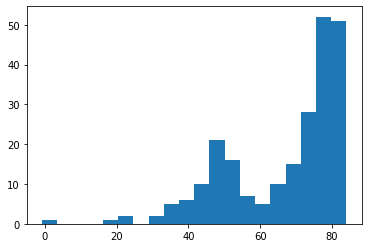

In [191]:
plt.hist(country_temps, bins=20)
plt.show()

Small bimodal curve. Capture the 2 humps in moderate and high climate by cutting in the dips. Prepare plots indicating where we may look to draw distinction of the climate categories.

/Users/travismark/Documents/DU Masters/Data_Science_Tools_1_COMP_4447/dst1_env/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/travismark/Documents/DU Masters/Data_Science_Tools_1_COMP_4447/dst1_env/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/travismark/Documents/DU Masters/Data_Science_Tools_1_COMP_4447/dst1_env/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/var/folders/j_/38n39dnj4z9gdmy4w2vpg1pr0000gn/T/

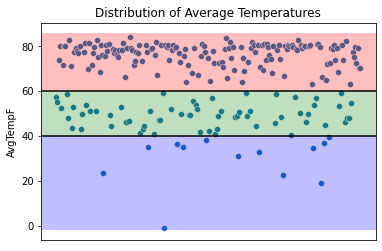

/Users/travismark/Documents/DU Masters/Data_Science_Tools_1_COMP_4447/dst1_env/lib/python3.9/site-packages/seaborn/categorical.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


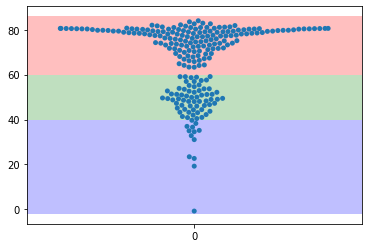

In [192]:
#Scatterplot with potential climate category lines
sns.scatterplot(data=country_temps)
plt.axhline(y = 60, color = 'black', linestyle = '-')
plt.axhline(y = 40, color = 'black', linestyle = '-')
plt.title('Distribution of Average Temperatures')
plt.xticks([])
plt.xlabel('')
plt.axhspan(60, 86, color='red', alpha=0.25, lw=0)
plt.axhspan(40, 60, color='green', alpha=0.25, lw=0)
plt.axhspan(-2, 40, color='blue', alpha=0.25, lw=0)
plt.show()

sns.swarmplot(data=country_temps)
plt.axhspan(60, 86, color='red', alpha=0.25, lw=0)
plt.axhspan(40, 60, color='green', alpha=0.25, lw=0)
plt.axhspan(-2, 40, color='blue', alpha=0.25, lw=0)
plt.show()

Here we will look to create the three climate categories by our arbitray drawing of the cutoff lines at 40 and 60 degrees. Create a categorical bin of 3 climates (cold, moderate, hot) based on the distribution of average temperatures.

In [193]:
climate=pd.DataFrame(country_temps)
climate['Climate']=pd.cut(country_temps,[-200,40,60,300],labels=['Cold','Moderate','Hot'])

View the United States for indication of climate.

In [194]:
climate[climate.index=='United States']

,AvgTempF,Climate
Country,,
United States,48.105324,Moderate


### Climate Clusters Using K-Means
Now we will utilize the k-means algorithm to identify 3 clusters. Using the k-means algorithm will ensure that we are creating categories which are minimizing the mean squared error distance of cluster observations, as opposed to our arbitrary drawing of the cutoffs.

In [195]:
#Convert the series to an array and reshape
temperatures=country_temps.array.reshape(-1, 1) 
#Create the KMeans model with 3 clusters
kmeans=KMeans(n_clusters=3, random_state=0)
kmeans.fit(temperatures)
#Get the cluster labels for each data point
clusters=kmeans.labels_

#Review the output of the model by printing the country, its temperature, and the corresponding cluster
for country, temp, cluster in zip(country_temps.index, temperatures, clusters):
    print(f"Country: {country} Temperature: {temp[0]}, Cluster: {cluster}")
#Create a new data frame with the country temps and add the associated cluster as a column
climate2=pd.DataFrame(country_temps)
climate2['climate']=clusters
#Map the cluster to a climate description
climate2['climate'].replace({0:'cold', 1:'hot', 2:'temperate'}, inplace=True)
climate2.sample()


Country: Afghanistan Temperature: 57.60653607038123, Cluster: 2
Country: Albania Temperature: 55.19476568914956, Cluster: 2
Country: Algeria Temperature: 73.87918137829912, Cluster: 1
Country: American Samoa Temperature: 80.09511715542521, Cluster: 1
Country: Andorra Temperature: 52.631964222873904, Cluster: 2
Country: Angola Temperature: 71.53222815249266, Cluster: 1
Country: Anguilla Temperature: 80.26054956011731, Cluster: 1
Country: Antigua And Barbuda Temperature: 79.94926964809385, Cluster: 1
Country: Argentina Temperature: 58.66672815249267, Cluster: 2
Country: Armenia Temperature: 48.018194721407625, Cluster: 2
Country: Aruba Temperature: 82.61806392961877, Cluster: 1
Country: Australia Temperature: 71.13224149560116, Cluster: 1
Country: Austria Temperature: 43.69283695014663, Cluster: 2
Country: Azerbaijan Temperature: 52.73993387096774, Cluster: 2
Country: Bahamas Temperature: 77.57485058651027, Cluster: 1
Country: Bahrain Temperature: 79.01605014662756, Cluster: 1
Country: B

,AvgTempF,climate
Country,,
Turkey,53.485312,temperate


Looking at the climate clusters assigned to gain confidence in the assignment of countries makes sense.  
Next, let's see what the center value of the clusters are.

In [196]:
#Investigate the centers of the clusters to see where they lie and how closely our arbitrary assignments worked
centers=kmeans.cluster_centers_.flatten()
print(np.sort(centers))

[28.76980913 49.59748965 76.50084486]


Our arbitrary categorization was very close to what was obtained in the k-means clustering algorithm. We'll plot the temperatures with their assigned cluster and overlay our arbitrary cut lines.

/Users/travismark/Documents/DU Masters/Data_Science_Tools_1_COMP_4447/dst1_env/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/travismark/Documents/DU Masters/Data_Science_Tools_1_COMP_4447/dst1_env/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/travismark/Documents/DU Masters/Data_Science_Tools_1_COMP_4447/dst1_env/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/travismark/Documents/DU Masters/Data_Scien

Text(0.5, 0, '')

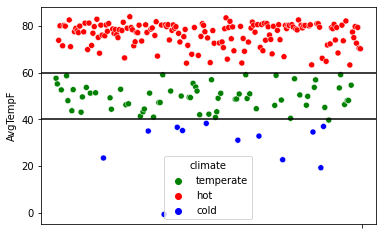

In [199]:
#Create a plot of the temperatures and the assigned cluster
sns.scatterplot(data=climate2, x=climate2.index, y='AvgTempF', hue='climate', palette=['g', 'r', 'b'], legend='full')
plt.axhline(y = 60, color = 'black', linestyle = '-')
plt.axhline(y = 40, color = 'black', linestyle = '-')
plt.xticks('')
plt.xlabel('')

Our best guess categorization and the k-means clustering only differed by 1 assignment. K-means drew the cutoff point of cold and temperate at a slightly lower temperature than the 40 degrees we had originally.

In [200]:
print(climate2.groupby('climate').count())
print(climate.groupby('Climate').count())

           AvgTempF
climate            
cold             12
hot             156
temperate        64
          AvgTempF
Climate           
Cold            13
Moderate        63
Hot            156


/var/folders/j_/38n39dnj4z9gdmy4w2vpg1pr0000gn/T/ipykernel_45087/2731724602.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(climate.groupby('Climate').count())


Now, we will visualize the temperature and climate data on a map.  
Reading in a geo json of countries' polygons to enable the map to be drawn and merging the climate data into a single data frame.

In [201]:
countries_geo=gpd.read_file('countries.geojson')
countries_df=pd.merge(countries_geo, climate2, how='left', left_on='name', right_on='Country')
countries_df

,id,name,geometry,AvgTempF,climate
0,AFG,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066...",57.606536,temperate
1,AGO,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...",71.532228,hot
2,ALB,Albania,"POLYGON ((20.59025 41.85540, 20.46317 41.51509...",55.194766,temperate
3,ARE,United Arab Emirates,"POLYGON ((51.57952 24.24550, 51.75744 24.29407...",82.177783,hot
4,ARG,Argentina,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000...",58.666728,temperate
...,...,...,...,...,...
175,PSE,West Bank,"POLYGON ((35.54566 32.39399, 35.54525 31.78251...",NaN,NaN
176,YEM,Yemen,"POLYGON ((53.10857 16.65105, 52.38521 16.38241...",79.393386,hot
177,ZAF,South Africa,"POLYGON ((31.52100 -29.25739, 31.32556 -29.401...",63.365396,hot
178,ZMB,Zambia,"POLYGON ((32.75937 -9.23060, 33.23139 -9.67672...",70.519724,hot


Plotting the average temperature of each country on the map. Missing countries will be indicated by cross hatching.

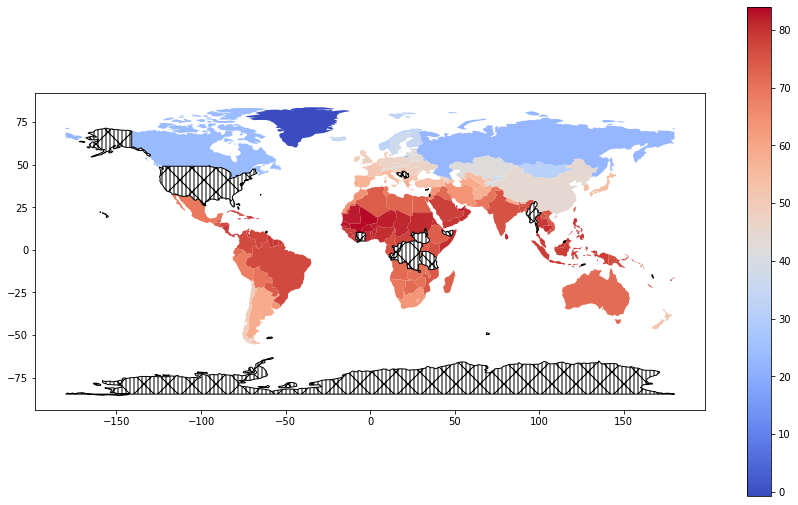

In [202]:
fig, ax=plt.subplots(figsize=(15, 9), alpha=0.5, edgecolor='k')
countries_df.plot(column='AvgTempF',
               cmap='coolwarm',
               #edgecolor='k',
               linewidth=1,
               legend=True,
               missing_kwds={'color': 'white',
                          'edgecolor': 'black',
                          'hatch': '|\|/|',
                          'label': 'Missing'},
               ax=ax)
plt.show()

Obviously, we are missing a few countries. We will address this.

We also want to see how the climate assignments look on a map.

In [203]:
temp_palette={'cold': 'blue', 'temperate': 'green', 'hot': 'red', np.NAN:'white'}

/var/folders/j_/38n39dnj4z9gdmy4w2vpg1pr0000gn/T/ipykernel_45087/2415538395.py:2: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  countries_df.plot(column='climate',


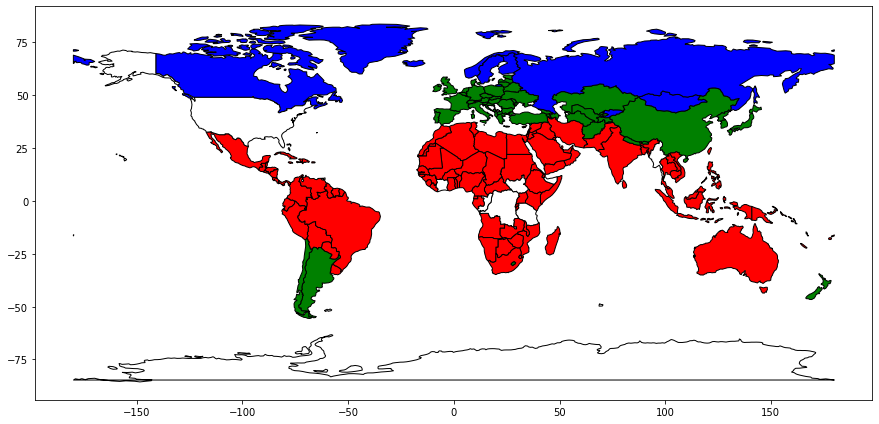

In [204]:
fig2, ax2=plt.subplots(figsize=(15, 9), alpha=0.5, edgecolor='k')
countries_df.plot(column='climate',
               #cmap='coolwarm',
               linewidth=1,
               legend=True,
               edgecolor='k',
               color=countries_df['climate'].map(temp_palette), 
               ax=ax2)
plt.show()

We can see we are missing a few countries, this would be due to differentiation of country names between the two merged data frames. We need to see a list of the countries which are missing data.

In [205]:
countries_df[countries_df['climate'].isnull()]
#climate2.reset_index
missing=pd.merge(countries_geo, climate2.reset_index(), how='outer', left_on='name', right_on='Country')
m2=pd.merge(climate2, countries_geo, how='outer', left_on='Country', right_on='name')
missing[(missing['climate'].isnull()) | (missing['name'].isnull())]
missing[missing['climate'].isnull()]

,id,name,geometry,Country,AvgTempF,climate
6,ATA,Antarctica,"MULTIPOLYGON (((-59.57209 -80.04018, -59.86585...",NaN,NaN,NaN
7,ATF,French Southern and Antarctic Lands,"POLYGON ((68.93500 -48.62500, 69.58000 -48.940...",NaN,NaN,NaN
17,BHS,The Bahamas,"MULTIPOLYGON (((-77.53466 23.75975, -77.78000 ...",NaN,NaN,NaN
18,BIH,Bosnia and Herzegovina,"POLYGON ((19.00549 44.86023, 19.36803 44.86300...",NaN,NaN,NaN
21,BMU,Bermuda,"POLYGON ((-64.77997 32.30720, -64.78733 32.303...",NaN,NaN,NaN
24,BRN,Brunei,"POLYGON ((114.20402 4.52587, 114.59996 4.90001...",NaN,NaN,NaN
32,CIV,Ivory Coast,"POLYGON ((-2.85613 4.99448, -3.31108 4.98430, ...",NaN,NaN,NaN
34,COD,Democratic Republic of the Congo,"POLYGON ((30.83386 3.50917, 30.77335 2.33988, ...",NaN,NaN,NaN
35,COG,Republic of the Congo,"POLYGON ((12.99552 -4.78110, 12.62076 -4.43802...",NaN,NaN,NaN
39,-99,Northern Cyprus,"POLYGON ((32.73178 35.14003, 32.80247 35.14550...",NaN,NaN,NaN


In [206]:
#climate2[climate2.index.str.contains('Island')]

After some investigation of the countries missing from the geo data frame. Since our initial temperature data did not have an element of the country code, we joined on the country names. We can see this join caused an issue with the naming convention of countries between the two data frames. To remedy we constructed a list of name in the climate data frame and what the corresponding name is in the geo data frame. Using these we performed a replace.

In [207]:
old=['United States','Bahamas','Congo','Congo (Democratic Republic Of The)','Côte D\'Ivoire','Tanzania','Burma','Serbia','Bosnia And Herzegovina','French Southern And Antarctic Lands','Trinidad And Tobago','Falkland Islands (Islas Malvinas)','Timor Leste']
new=['United States of America','The Bahamas','Republic of the Congo','Democratic Republic of the Congo','Ivory Coast','United Republic of Tanzania','Myanmar','Republic of Serbia','Bosnia and Herzegovina','French Southern and Antarctic Lands','Trinidad and Tobago','Falkland Islands','East Timor']
climate2=climate2.reset_index()
climate2['Country'].replace(old,new, inplace=True)
#climate2

Now that we have performed our cleaning, we'll join the data frames back together into a cleaned data frame for visualization.

/var/folders/j_/38n39dnj4z9gdmy4w2vpg1pr0000gn/T/ipykernel_45087/4156335544.py:4: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  countries_df_cleaned.plot(column='climate',


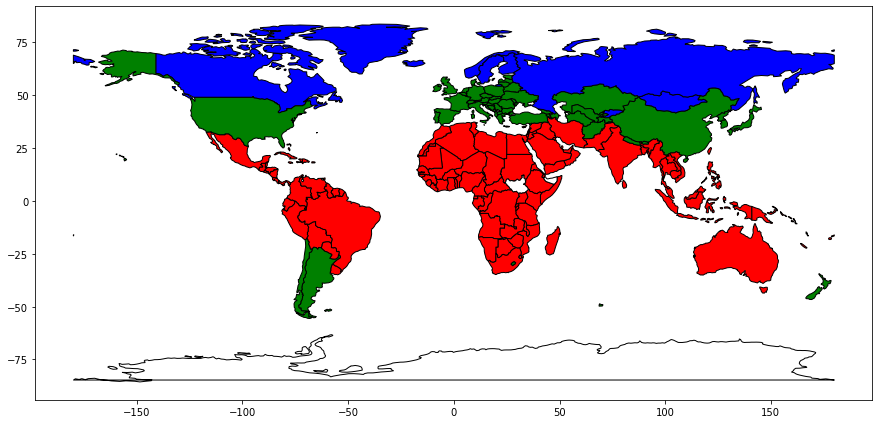

In [208]:
countries_df_cleaned=pd.merge(countries_geo, climate2, how='outer', left_on='name', right_on='Country')

fig3, ax3=plt.subplots(figsize=(15, 9), alpha=0.5, edgecolor='k')
countries_df_cleaned.plot(column='climate',
               linewidth=1,
               legend=True,
               edgecolor='k',
               color=countries_df_cleaned['climate'].map(temp_palette),
               ax=ax3)
plt.show()

We can see there are still a few missing countires.

In [209]:
countries_df_cleaned[countries_df_cleaned['climate'].isnull()]

,id,name,geometry,Country,AvgTempF,climate
6,ATA,Antarctica,"MULTIPOLYGON (((-59.57209 -80.04018, -59.86585...",NaN,NaN,NaN
21,BMU,Bermuda,"POLYGON ((-64.77997 32.30720, -64.78733 32.303...",NaN,NaN,NaN
24,BRN,Brunei,"POLYGON ((114.20402 4.52587, 114.59996 4.90001...",NaN,NaN,NaN
39,-99,Northern Cyprus,"POLYGON ((32.73178 35.14003, 32.80247 35.14550...",NaN,NaN,NaN
90,CS-KM,Kosovo,"POLYGON ((20.76216 42.05186, 20.71731 41.84711...",NaN,NaN,NaN
142,SSD,South Sudan,"POLYGON ((33.96339 9.46429, 33.97498 8.68456, ...",NaN,NaN,NaN
147,-99,Somaliland,"POLYGON ((48.93813 9.45175, 48.48674 8.83763, ...",NaN,NaN,NaN
174,VUT,Vanuatu,"MULTIPOLYGON (((167.84488 -16.46633, 167.51518...",NaN,NaN,NaN
175,PSE,West Bank,"POLYGON ((35.54566 32.39399, 35.54525 31.78251...",NaN,NaN,NaN


After investigation into this missing countires, we found that Bermuda, Brunei, Kosovo, Vanuatu, and West Bank were not listed in the the temperature data. In the instance of Northern Cyprus, Cyprus was listed in the temperature data but not Northern Cyprus.  
Sudan is listed in both the temperature and geography data and is mapped as such. However, South Sudan is not provided in the temperature data. A reason for this may be that South Sudan gained independence in 2011 and our temperature data is provided through 2013. So, the map shown maybe more up to date than our temperature data is.  
Similarly, Somalia is listed both data sets, but there is no temperature data for Somaliland. A search on Google indicates that Somaliland is an autonomous region in northern Somalia. While Somaliland is self-governing, no foreign governments recognize it. This could likely explain the discrepancy on the map.

In [210]:
countries_df_cleaned[countries_df_cleaned['geometry'].isnull()]

,id,name,geometry,Country,AvgTempF,climate
180,NaN,NaN,None,American Samoa,80.095117,hot
181,NaN,NaN,None,Andorra,52.631964,temperate
182,NaN,NaN,None,Anguilla,80.260550,hot
183,NaN,NaN,None,Antigua And Barbuda,79.949270,hot
184,NaN,NaN,None,Aruba,82.618064,hot
...,...,...,...,...,...,...
236,NaN,NaN,None,South Georgia And The South Sandwich Isla,34.581059,cold
237,NaN,NaN,None,Svalbard And Jan Mayen,19.265252,cold
238,NaN,NaN,None,Tonga,74.019692,hot
239,NaN,NaN,None,Turks And Caicas Islands,80.384342,hot


Looking at the join in the other direction, there are 61 countries with temperature reported, but do not have geometry data and are therefore not shown on the map. Some of these countries, like American Samoa or United States Virgin Islands, are territories. These may still have Olympic teams. Others, like Bahrain, are not included in the geography polygons and have participated in the Olympics. To ensure we capture as many countries as possible with their climate data and ultimately merging it to the Olympics data, we will outer join the climate and geography data in our final data frame.

#### Average Temperature Map

Plotting of the average temperature map.

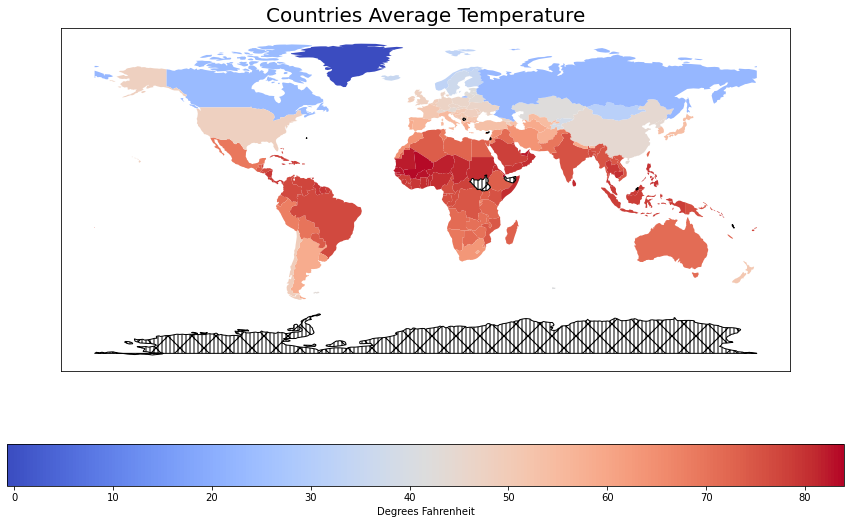

In [211]:
fig, ax=plt.subplots(figsize=(15, 9), alpha=0.5, edgecolor='k')
countries_df_cleaned.plot(column='AvgTempF',
               cmap='coolwarm',
               #edgecolor='k',
               linewidth=1,
               legend=True,
               missing_kwds={'color': 'white',
                          'edgecolor': 'black',
                          'hatch': '|\|/|',
                          'label': 'Missing'},
               legend_kwds={'label': 'Degrees Fahrenheit', 'orientation': 'horizontal'},
               ax=ax)
ax.set_title('Countries Average Temperature', fontsize=20)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.show()

#### Climate Map

Final plotting of the climate map, with tropic and arctic lines overlayed for reference.

/var/folders/j_/38n39dnj4z9gdmy4w2vpg1pr0000gn/T/ipykernel_45087/2193066526.py:5: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  countries_df_cleaned.plot(column='climate',


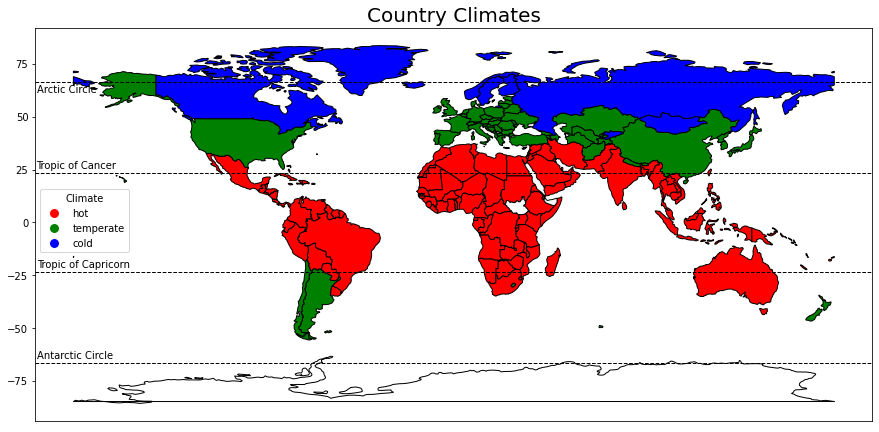

In [212]:
#from matplotlib.colors import ListedColormap


fig3, ax3=plt.subplots(figsize=(15, 9), alpha=0.5, edgecolor='k')
countries_df_cleaned.plot(column='climate',
                                          linewidth=1,
                                          legend=True,
                                          edgecolor='k',
                                          color=countries_df_cleaned['climate'].map(temp_palette),
                                          ax=ax3)

#Adding reference lines for the Tropic of Cancer and the Tropic of Capricorn
ax3.axhline(y=23.5, color='black', linestyle='--', linewidth=1)  # Tropic of Cancer
ax3.axhline(y=-23.5, color='black', linestyle='--', linewidth=1)  # Tropic of Capricorn
#Adding reference lines for the Arctic Circle and the Antarctic Circle
ax3.axhline(y=66.5, color='black', linestyle='--', linewidth=1)  # Arctic Circle
ax3.axhline(y=-66.5, color='black', linestyle='--', linewidth=1)  # Antarctic Circle

#Adding labels for the tropic lines and the arctic circle lines on the left side of the map using the min x-coordinate on the map
min_x=countries_df_cleaned.total_bounds[0]
#Adjust the label position
ax3.text(min_x + 20, 25.5, 'Tropic of Cancer', ha='right', color='black')
ax3.text(min_x + 27, -21.5, 'Tropic of Capricorn', ha='right', color='black')
ax3.text(min_x + 11, 61.5, 'Arctic Circle', ha='right', color='black')
ax3.text(min_x + 19, -64.5, 'Antarctic Circle', ha='right', color='black')


#Adding a custom legend
legend_dict={k: plt.Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v, markersize=10) for k, v in temp_palette.items() if not isinstance(k, float)}
handles=list(legend_dict.values())[::-1]  
#Reverse the order of handles
labels=[h.get_label() for h in handles]
ax3.legend(handles=handles, labels=labels, loc='center left', title='Climate', bbox_to_anchor=(0,.51))
ax3.set_title('Country Climates', fontsize=20)
ax3.set_xticks([])
plt.show()

